In [3]:
import re
import os
import pickle
import numpy as np
import pandas as pd
import importlib.util #import from superordinate folder
spec = importlib.util.spec_from_file_location("helper", 
                                              str(re.search("(.*/)",os.getcwd()).groups(0)[0])+"helper.py")
helper = importlib.util.module_from_spec(spec)
spec.loader.exec_module(helper)

In [4]:
#Now you can zoom
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
prefix = "RPS_C_13_C3_left_"

In [6]:
with open("DualEEG_RPS_C_13.power_common_reference","rb") as f:
    power_p1_p2 = pickle.load(f)
    
power = {}#Get back power of participant1 only
for k in [k for k in list(power_p1_p2.keys()) if re.search("_1",k)]:
    power[k] = power_p1_p2[k]

In [7]:
times = helper.get_trial_times(helper.parse_vmrk("DualEEG_RPS_C_13.vmrk"))

In [8]:
with open("1d_movement.motion","rb") as f:
    one_d = pickle.load(f)
with open("2d_movement.motion","rb") as f:
    two_d = pickle.load(f)

In [9]:
one_d[prefix+"head"].shape

(17980,)

In [10]:
power["alpha_F7_1"].shape

(17934,)

## Additional helper methods

In [11]:
def print_table(dataframe, heading = " ", heading_indent = 4, subtext ="",three_levels = False):
    heading = heading.replace("\\t","&nbsp;&nbsp;&nbsp;&nbsp;")
    heading = heading.replace(" ","&nbsp;")
    subtext = subtext.replace("\\t","&nbsp;&nbsp;&nbsp;&nbsp;")
    subtext = subtext.replace("\\n","<br>")

    if type(dataframe) == dict:
        if three_levels:
            dataframe = df_from_nested_dict(dataframe)
        else:
            dataframe = pd.DataFrame.from_dict(dataframe)

    dataframe = pd.DataFrame(dataframe)
    
    html_string = dataframe.to_html()
    
    
    html_string = html_string.replace("\\t","&nbsp;&nbsp;&nbsp;&nbsp;")
    html_string = html_string.replace("\\n","<br>")
    html_string = html_string.replace('<table border="1" class="dataframe">', '<table border="{}" cellpadding="{}" cellspacing="0" class="dataframe">'.format(10,10))
    

    
    display(HTML(  '<html>'
                 + '<h4 style="color: DarkBlue;text-align: left; padding-left:{0:3}px;">'.format(heading_indent)
                 + heading
                 + '</h4>'
                 + html_string
                 + '<div style="font-size: 12px">'
                 + subtext
                 + "</div>"
                 + "</html>"))

def df_from_nested_dict(d):
    return pd.DataFrame.from_dict({(i,j): d[i][j] for i in d.keys() for j in d[i].keys()},orient='index')

## 1. Assemble Dataset

In [12]:
datadict = {}
datadict["head"] = one_d['RPS_C_13_C3_left_head']
datadict["hands"] = one_d['RPS_C_13_C3_left_hands']
datadict["body"] = one_d['RPS_C_13_C3_left_body']

In [13]:
for k, v in two_d.items():
    for x, name in zip(v, ["up","left","down","right"]):
        if "RPS_C_13_C3_left_head" in k:
            datadict["head"+"_"+name] = x
        elif "RPS_C_13_C3_left_hands" in k:
            datadict["hands"+"_"+name] = x
        elif "RPS_C_13_C3_left_body" in k:
            datadict["body"+"_"+name] = x

In [14]:
datadict = {**datadict,**power}

In [15]:
maxshift = 3*25 #discard initial 3 seconds 
for shift,name in zip ([-3*25,-2*25,-1*25,1*25,2*25,3*25],["shift_m3_","shift_m2_","shift_m1_","shift_1_","shift_2_","shift_3_"]):
    he = list(np.zeros(maxshift))
    he.extend(list(one_d['RPS_C_13_C3_left_head']))
    ha = list(np.zeros(maxshift))
    ha.extend(list(one_d['RPS_C_13_C3_left_hands']))
    bo = list(np.zeros(maxshift))
    bo.extend(list(one_d['RPS_C_13_C3_left_body']))
    
    he = np.array(he)
    ha = np.array(ha)
    bo = np.array(bo)
    
    datadict[name+"head"] = he[shift+maxshift:]
    datadict[name+"hands"] = ha[shift+maxshift:]
    datadict[name+"body"] = bo[shift+maxshift:]

In [16]:
minsize = np.min(np.array([x.shape[0] for x in datadict.values()]))
for k, v in datadict.items():
    datadict[k] = v[:minsize]

In [17]:
#df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in datadict.items() ]))
df = pd.DataFrame.from_dict(datadict)

In [18]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.ticker as mticker

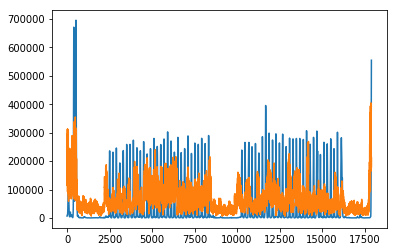

In [19]:
plt.plot(df["hands"]*500)
plt.plot(df["alpha_F7_1"])

# 2. Crosscorrelation and time-shift analysis

In [414]:
bounds = 1
alpha = [v[bounds:-bounds] for k, v in df.items() if re.search("alpha",k)]
alpha_trial = [v[2500:7500] for k, v in df.items() if re.search("alpha",k)]
gamma = [v[bounds:-bounds] for k, v in df.items() if re.search("gamma",k)]
gamma_trial =[v[2500:7500] for k, v in df.items() if re.search("gamma",k)]

head_complete = df["head"][bounds:-bounds]
head_trial = df["head"][2500:7500]
hands_complete = df["hands"][bounds:-bounds]
hands_trial = df["hands"][2500:7500]

......................................................................................................................................................

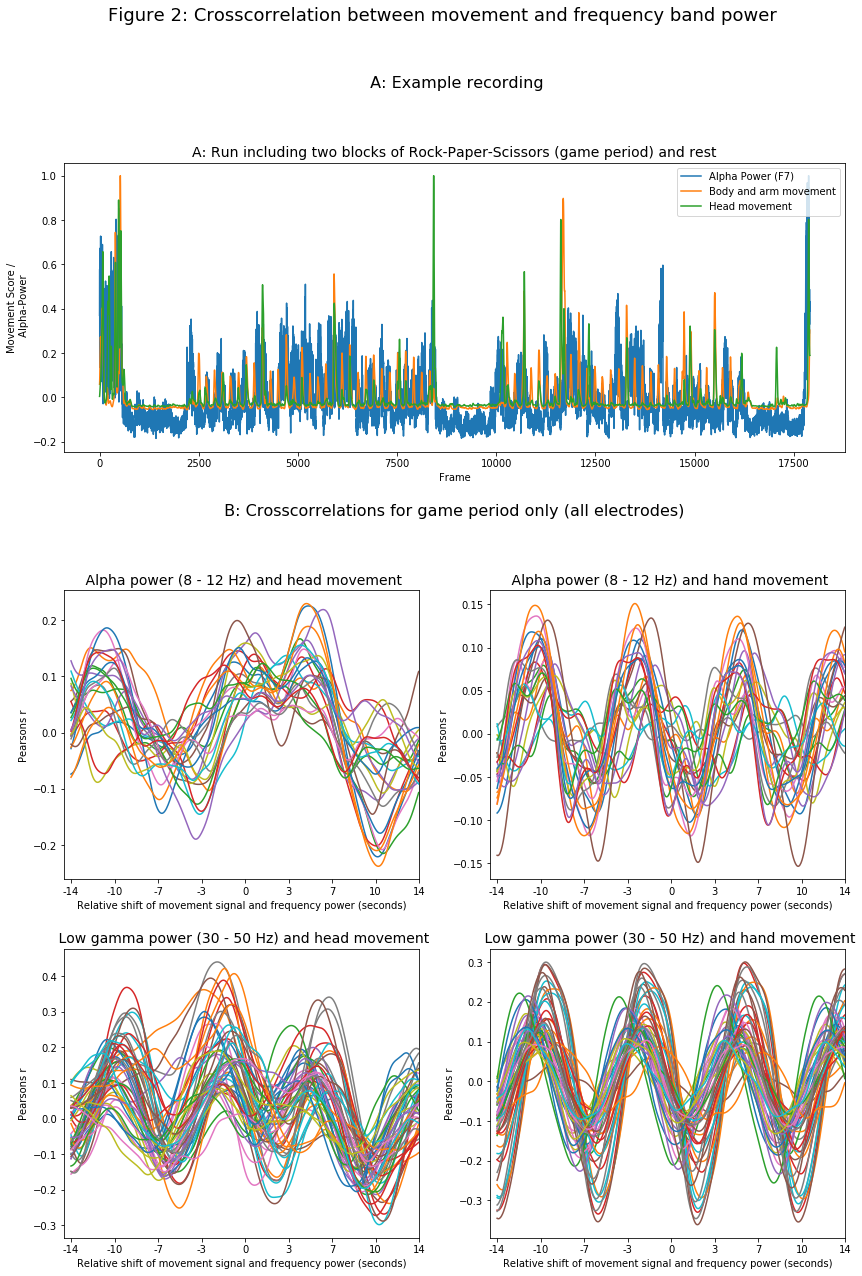

In [415]:
import matplotlib.pyplot as plt
gam = df["alpha_F7_1"]
body = df["body"]
head = df["head"]
hands = df["hands"]


body = body-np.mean(body)
head = head-np.mean(head)
hands = hands-np.mean(hands)

gam = gam-np.nanmean(gam)

#Generate new figure and define arrangement via grid specification

fig = plt.figure(figsize=(14, 20))
fig.subplots_adjust(top=0.92, wspace = 0.2, hspace=.4)

fig.suptitle("Figure 2: Crosscorrelation between movement and frequency band power", fontsize=18)
gs = gridspec.GridSpec(5, 2,width_ratios=[1, 1],height_ratios=[0.001,2,0.001,2,2])

ax_empty0 = plt.subplot(gs[0,:])
ax1 = plt.subplot(gs[1,:])
ax_empty1 = plt.subplot(gs[2,:])
ax2 = plt.subplot(gs[3,0])
ax3 = plt.subplot(gs[3,1])
ax4 = plt.subplot(gs[4,0])
ax5 = plt.subplot(gs[4,1])


#Turn off ticks
ax_empty0.axis("off")
ax_empty0.axis("off")
ax_empty0.set_title(" A: Example recording", fontsize=16)

ax_empty1.axis("off")
ax_empty1.axis("off")
ax_empty1.set_title(" B: Crosscorrelations for game period only (all electrodes) ", fontsize=16)


# 1: Add first subplot: Sample trial alpha power and movement signals (unsmoothed)
ax1.plot((gam/np.max(gam)), label="Alpha Power (F7)")
ax1.plot(body/np.max(body), label="Body and arm movement")
ax1.plot(head/np.max(head), label="Head movement")
ax1.legend(loc='best')
ax1.set_xlabel("Frame")
ax1.set_ylabel("Movement Score /\n Alpha-Power")
ax1.set_title("A: Run including two blocks of Rock-Paper-Scissors (game period) and rest", fontsize = 14)

# 2: Add rest
maxshift = 350

titles = []
titles.append(" Alpha power (8 - 12 Hz) and head movement")
titles.append(" Alpha power (8 - 12 Hz) and hand movement")

titles.append(" Low gamma power (30 - 50 Hz) and head movement")
titles.append(" Low gamma power (30 - 50 Hz) and hand movement")


for ax, powers, mot, title in zip([ax2,ax3,ax4,ax5],[alpha_trial,alpha_trial,gamma_trial,gamma_trial],
                      [head_trial,hands_trial,head_trial,hands_trial],titles):
    ax.set_xlim(-14,14)

    ax.set_xticks(np.linspace(0,2*maxshift,9))
    ax.set_xticklabels(np.linspace(-maxshift/25,maxshift/25,9, dtype =np.int32))
    ax.set_xlabel("Relative shift of movement signal and frequency power (seconds)")
    ax.set_ylabel("Pearsons r")
    ax.set_title(title, fontsize = 14)

    for train in powers:
        print(".", end = "")
        if np.any(np.isnan(train)):
            print("Nan in eeg for" + title)
            train[np.isnan(train)] =0
        if np.any(np.isnan(mot)):
            print("Nan in motion for" + title)
            mot[np.isnan(mot)] =0
        c = helper.correlation_shifted(mot,train,maxshift)[0]#We shift eeg relative to motion
        ax.plot(c)

Correlation peaks shortly before zero. If movement is delayed for two seconds there is the strongest positive correlation. 
Possibly, artifacts are generated shortly before movement peaks (if movement is delayed the peak overlaps with the peak in EEG-power causing positive correlation).
An interpretation is that those muscles affecting the EEG signal strongest are active when participants lift their hands to play another round of Rock-Paper and Scissors.
The fact that correlation is stronger in higher frequencies indicates that the effect is rather due to muscle activity then neuronal processes. 
One would expect muscle activity to occur in higher frequencies.

# Correlations and cross-correlations for the dataset

In [20]:
from collections import defaultdict
import seaborn as sns

## Inspection of correlations of the whole dataset

In [21]:
df.iloc[:,0:].corr().round(1).head()

,head,hands,body,head_up,head_left,head_down,head_right,hands_up,hands_left,hands_down,...,shift_m1_body,shift_1_head,shift_1_hands,shift_1_body,shift_2_head,shift_2_hands,shift_2_body,shift_3_head,shift_3_hands,shift_3_body
head,1.0,0.4,0.6,0.6,0.6,0.5,0.6,0.2,0.2,0.3,...,0.4,0.6,0.2,0.4,0.3,0.2,0.3,0.3,0.1,0.2
hands,0.4,1.0,0.8,0.2,0.3,0.1,0.2,0.7,0.7,0.7,...,0.4,0.3,0.4,0.4,0.1,-0.0,0.1,0.1,-0.1,-0.1
body,0.6,0.8,1.0,0.3,0.4,0.2,0.3,0.6,0.5,0.6,...,0.6,0.4,0.4,0.6,0.2,-0.0,0.2,0.1,-0.1,-0.0
head_up,0.6,0.2,0.3,1.0,0.3,0.1,0.5,0.2,0.1,0.2,...,0.1,0.2,0.1,0.1,0.1,0.0,0.1,0.1,-0.0,0.0
head_left,0.6,0.3,0.4,0.3,1.0,0.3,0.2,0.3,0.2,0.2,...,0.2,0.3,0.1,0.3,0.1,0.1,0.3,0.2,0.1,0.2


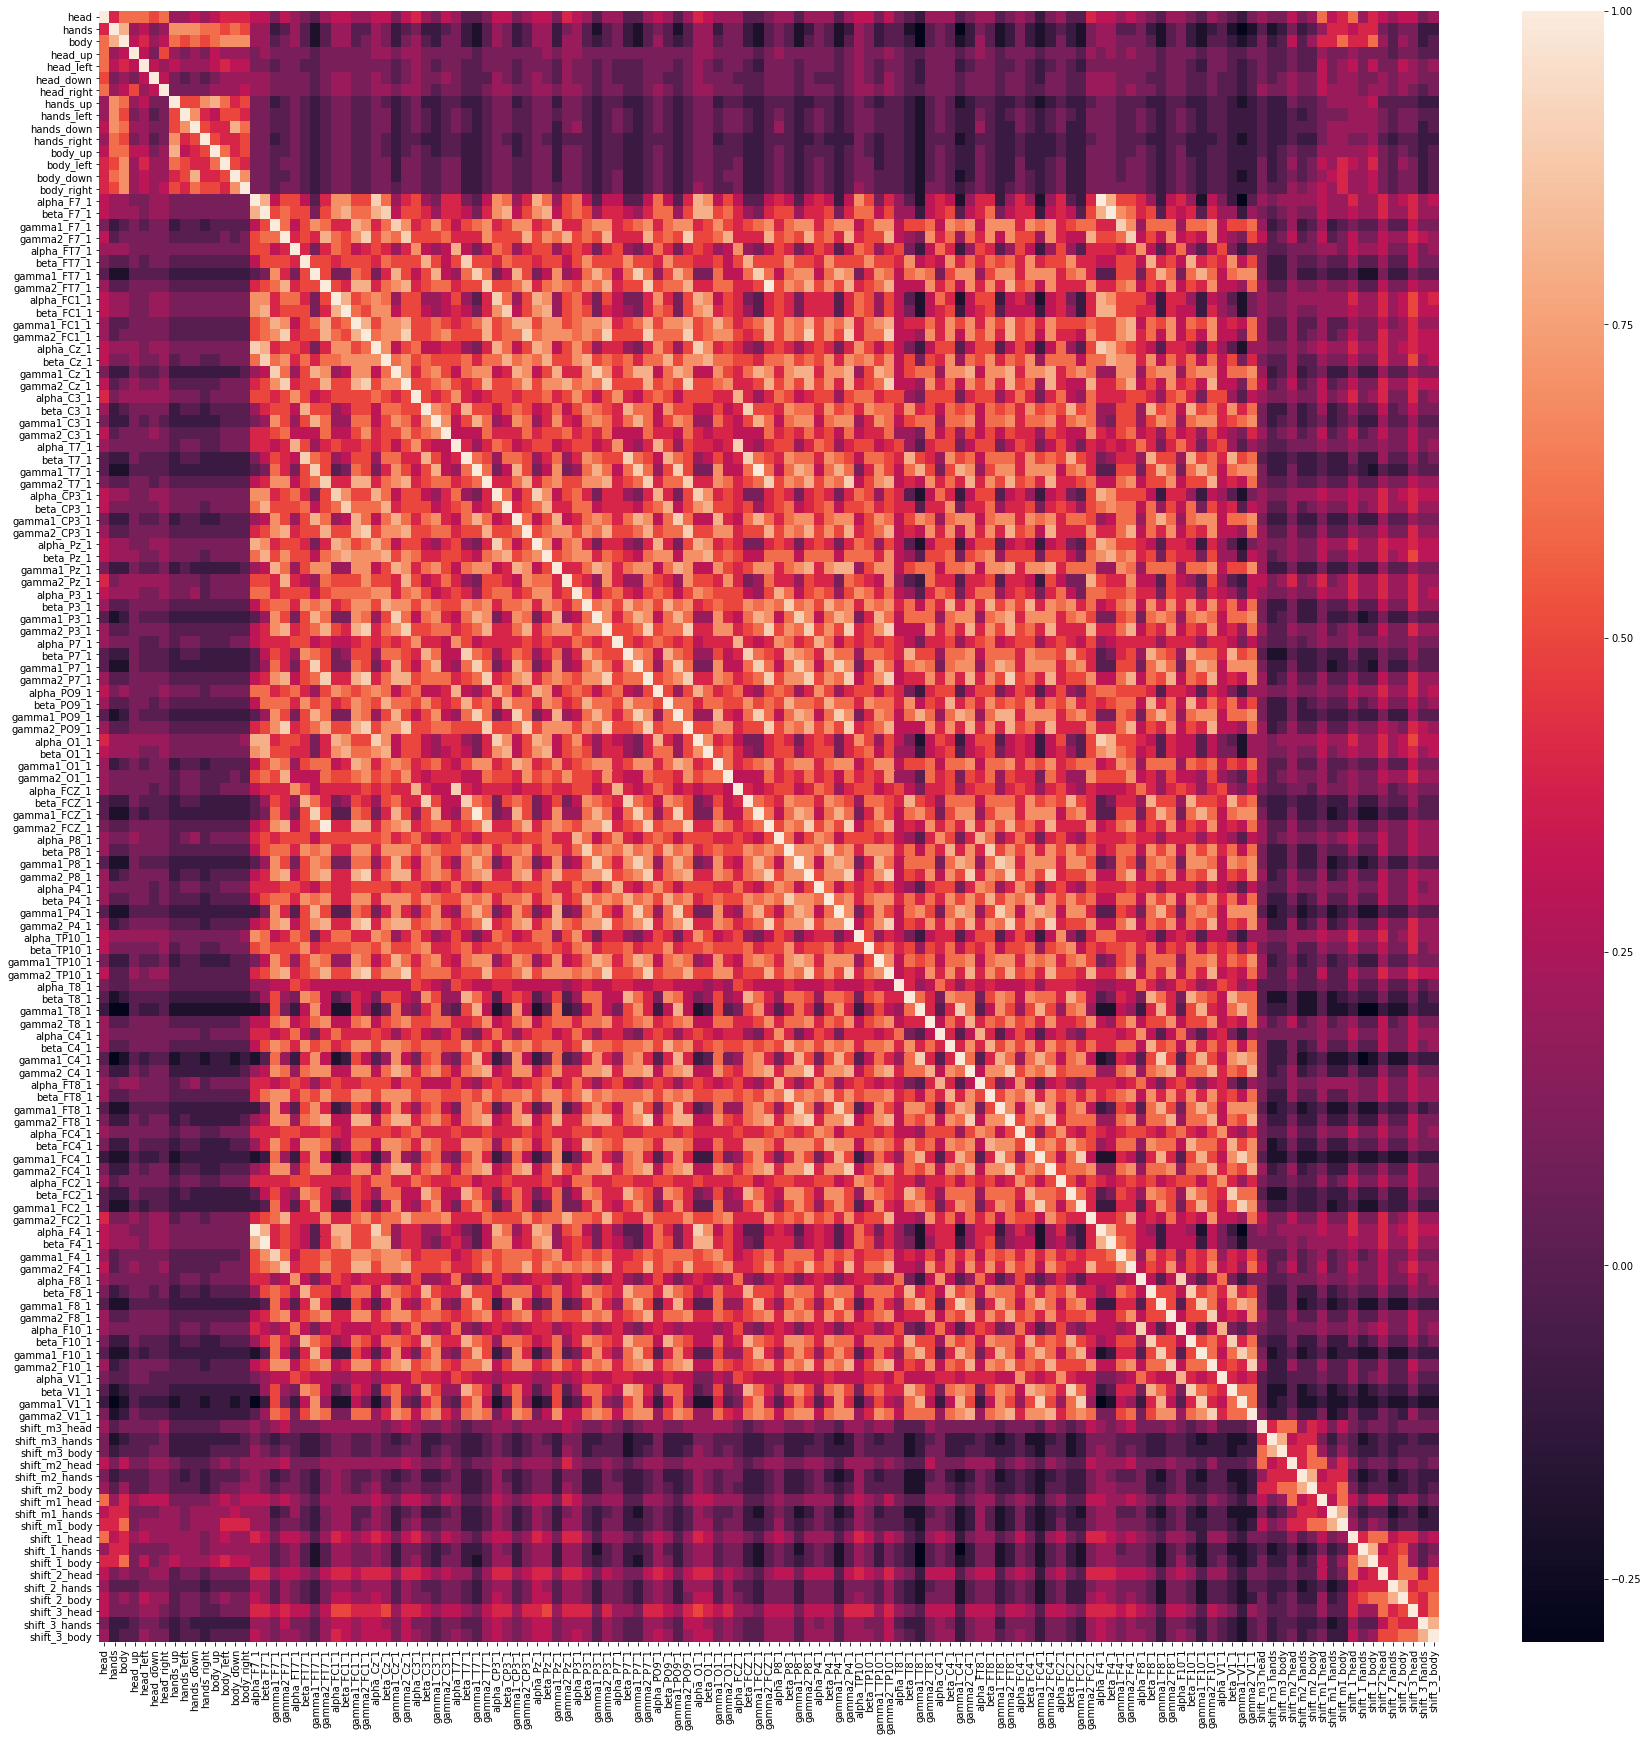

In [417]:
#Check for intercorrelations of 1d motion first
plt.figure(figsize=(30,30))
sns.heatmap(df.iloc[:,0:].corr().round(1), annot=False)

### Conclusions:

- We have high multicolinearity between motion channels (1D signal for motion score)
- Very high multicolinearity also exists between motion directions (2d signal for up, down, right, left)
- It shows that that higher correlations between motion and EEG-Power occur for the shifted 1D motion signal as compared to the non-shifted 1D signal (further investigations below)

## Game period correlations of the non-shifted 1D and 2d motion signal and EEG power

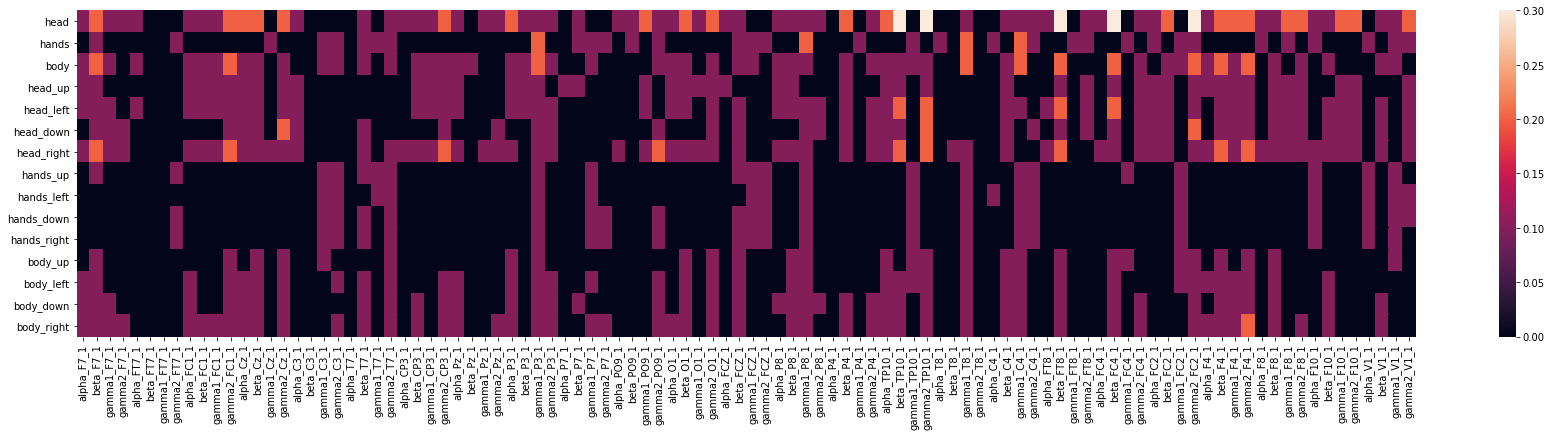

In [22]:
#Check for intercorrelations of 1d motion first
plt.figure(figsize=(30,6))
sns.heatmap(df.iloc[2500:7500,:].corr().round(1).abs().iloc[:15,15:-18], annot=False)

## Within trial period correlations of the shifted 1D motion signal and EEG power

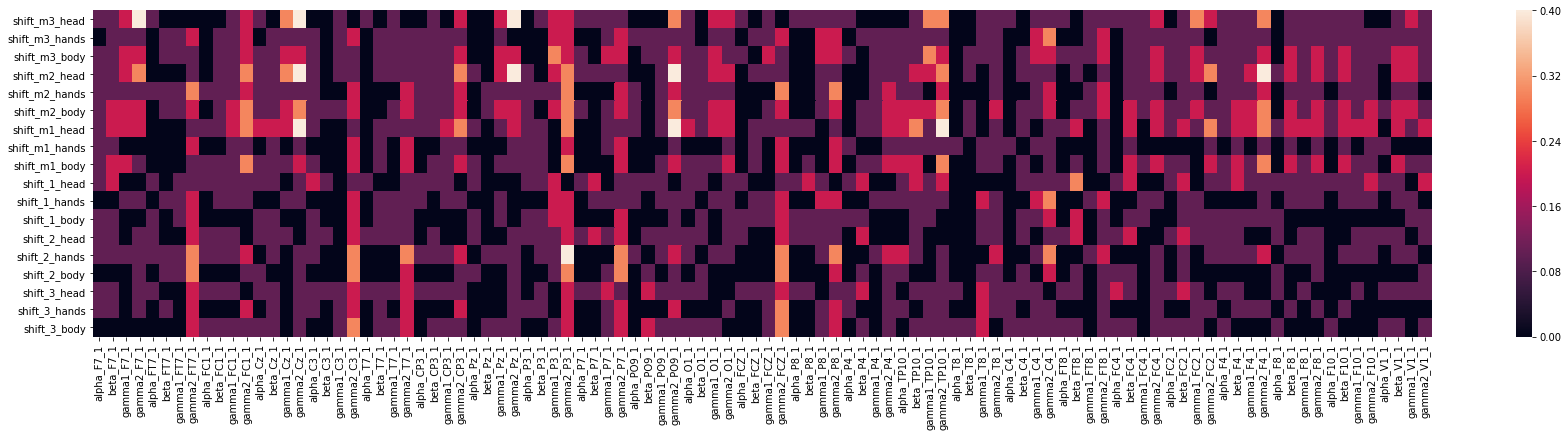

In [23]:
plt.figure(figsize=(30,6))
sns.heatmap(df.iloc[2500:7500,:].corr().round(1).abs().iloc[115:,15:-18], annot=False)

It shows that correlations are higher. What is a good shift for better predictions of EEG power given the motion signal?

In [24]:
pd.DataFrame(df.iloc[2500:7500,:].corr().round(1).abs().iloc[115:,15:-18].sum(axis=1))

,0
shift_m3_head,9.8
shift_m3_hands,8.6
shift_m3_body,11.4
shift_m2_head,11.9
shift_m2_hands,8.7
shift_m2_body,12.8
shift_m1_head,12.7
shift_m1_hands,5.2
shift_m1_body,9.8
shift_1_head,8.4


A good shift is minus two (if the peak of motion comes two seconds early there is a higher correlation indicating that for the given task a movement related error signal is strongest before/in the inital phase of movement). Now (1) how dows the overall picture for different regions look like and (2) how does the topographical organisation look like?

# Overall (best) correlation of movement and EEG Power for motion ROIs and Frequency bands 

## Prepare dictionaries to accumultate information to be printed in table

For each region for each 1D movement signal. Compute crosscorellations within +3 to -3 seconds. Save the correlation as well as its significance (corrected for the number of comparisons for channels and ROIs, 25X3) to a default dict.
Print the results as a table

In [25]:
alpha = [v[2500:7500] for k, v in df.items() if re.search("alpha",k)]
beta = [v[2500:7500] for k, v in df.items() if re.search("beta",k)]
gamma1 = [v[2500:7500] for k, v in df.items() if re.search("gamma1",k)]
gamma2 = [v[2500:7500] for k, v in df.items() if re.search("gamma2",k)]

head = df["head"][2500:7500]
hands = df["hands"][2500:7500]
body = df["body"][2500:7500]

In [26]:
from scipy import ndimage
from scipy import stats
from IPython.display import HTML

In [27]:
pearsons_r = defaultdict(lambda: defaultdict(dict))
pearsons_r_shifted = defaultdict(lambda: defaultdict(dict))
n_sig = defaultdict(lambda: defaultdict(dict))
n_large = defaultdict(lambda: defaultdict(dict))
mean_shift = defaultdict(lambda: defaultdict(dict))

summery = defaultdict(lambda: defaultdict(dict))

In [28]:
names_regions = ["Head Region", "Body Region", "Hands region"]
names_bands = ["Alpha Power", "Beta power", "Low Gamma Power","High Gamma Power"]
for region, name_region in zip([head, hands, body],names_regions):
    for band, name_band in zip([alpha, beta, gamma1, gamma2],names_bands):
        mean = 0
        n_greater = 0
        optimal_shift = 0
        mean_p = 0
        
        n_sig_corr = 0
        for electrode in band:
            #region = ndimage.filters.gaussian_filter1d(region,50)
            #band = ndimage.filters.gaussian_filter1d(region,2)
            
            corr, ps = helper.correlation_shifted(region,electrode,75)#shift movement relative to power
            if np.max(np.abs(corr)) >= .2:
                n_greater += 1
                
            shift = np.argwhere(corr==np.max(corr))[0][0]
            optimal_shift += shift-75
            
            mean += np.max(np.abs(corr))
            mean_p += ps[shift]
            
            if ps[shift]<0.05/(25*3):
                n_sig_corr+=1
            #print("{0:1.4f}".format(ps[shift]))
            #print(np.max(np.abs(corr)))
        
        mean = mean/len(band)
        optimal_shift = optimal_shift/len(band)
        
        pearsons_r_shifted[name_region][name_band] = mean
        n_large[name_region][name_band]  = n_greater
        mean_shift[name_region][name_band]  = optimal_shift
        n_sig[name_region][name_band] = n_sig_corr
        
        summery[name_region][name_band] = "\t \t \t"+str(n_sig_corr) + "  ( r = {0:1.2f}, shift = {1:1.1f} s )".format(mean,optimal_shift/25)
        
        if(False):            
            print()
            print(name_region)
            print(name_band)
            print("Mean r: ")

            print(mean)
            print("Greater than .2:")
            print(n_greater)
            print("Mean shift for optimal correlation")
            print(optimal_shift)

In [29]:
print_table(summery,'Table 1: \t Number of electrodes with a significant correlation of shifted movement and bandpower',4, 
            "Values in parentheses refer to mean correlation and optimal shift. Significance at p* < .05. Corrected for multiple comparisons. N = 5000")

,Head Region,Body Region,Hands region
Alpha Power,"23 ( r = 0.12, shift = 0.7 s )","15 ( r = 0.07, shift = -1.3 s )","24 ( r = 0.10, shift = -0.0 s )"
Beta power,"24 ( r = 0.17, shift = 0.7 s )","21 ( r = 0.09, shift = -2.1 s )","24 ( r = 0.14, shift = -0.8 s )"
High Gamma Power,"25 ( r = 0.26, shift = -1.3 s )","25 ( r = 0.20, shift = -2.1 s )","25 ( r = 0.25, shift = -1.9 s )"
Low Gamma Power,"23 ( r = 0.16, shift = -1.2 s )","25 ( r = 0.13, shift = -2.2 s )","25 ( r = 0.17, shift = -2.1 s )"


# Movement based predictions

- Delayed vs. non delayed
- Delayed and 1d 2d signal
- Linear vs. polynominal regression

In [136]:
game_period = df.loc[2500:7500]

In [156]:
if False:
    print(np.array(game_period.keys()))
    plt.figure(figsize=(20, 5))

    features = ['head', 'hands', "shift_m2_head", "shift_2_head", "shift_1_head", "shift_m1_head"]
    target = game_period['alpha_O1_1']

    for i, col in enumerate(features):
        plt.subplot(1, len(features) , i+1)
        x = game_period[col]
        y = target
        plt.scatter(x, y, marker='o')
        plt.title(col)
        plt.xlabel(col)

In [175]:
X1 = dict(game_period.loc[:,"shift_m3_head":"shift_3_body"])
X2 = dict(game_period.loc[:,"head":"body_right"])
X = {**X1,**X2}#Information from the past and the future

X = pd.DataFrame.from_dict(X)

Y = game_period['gamma1_F7_1']

In [176]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(4000, 15)
(1001, 15)
(4000,)
(1001,)


In [177]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [178]:
# model evaluation for training set
y_train_predict = lin_model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = lin_model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 16307.361927704887
R2 score is 0.05272873557392599


The model performance for testing set
--------------------------------------
RMSE is 16565.77123420028
R2 score is 0.054362855505008634


In [179]:
from sklearn.preprocessing import PolynomialFeatures
from RegscorePy import aic

def polynomial_regression(X_train,X_test, Y_train,Y_test ,degree):
    "Polynomial regression model for the given degree"

    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train)# transform existing features to higher degree features.
    poly_model = LinearRegression()  # fit the transformed features to Linear Regression
    poly_model.fit(X_train_poly, Y_train)

    y_train_predicted = poly_model.predict(X_train_poly)# predicting on training data-set
    y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))# predicting on test data-set

    #Calculate performance measures
    aic_value = aic.aic(Y_train,y_train_predicted,len(poly_features.get_feature_names(X_train.columns)))

    rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_predicted))  # evaluating the model on training dataset
    r2_train = r2_score(Y_train, y_train_predicted)

    rmse_test = np.sqrt(mean_squared_error(Y_test, y_test_predict))  # evaluating the model on test dataset
    r2_test = r2_score(Y_test, y_test_predict)
    
    pearson_corr_pred_test = np.corrcoef(Y_test, y_test_predict)[0,1]
    
    return aic_value, y_test_predict, pearson_corr_pred_test, rmse_train, r2_train, rmse_test, r2_test


In [180]:
aic_value, y_pred, r, rmse_train, r2_train, rmse_test, r2_test = polynomial_regression(X_train,X_test, Y_train,Y_test ,2)

print("The model performance for the training set")
print("-------------------------------------------")
print("RMSE of training set is {}".format(rmse_train))
print("R2 score of training set is {}".format(r2_train))

print("\n")

print("The model performance for the test set")
print("-------------------------------------------")
print("RMSE of test set is {}".format(rmse_test))
print("R2 score of test set is {}".format(r2_test))
print("AIC is {}".format(aic_value))
print("The correlation between prediction and true values for the test set is {}".format(r))

The model performance for the training set
-------------------------------------------
RMSE of training set is 15729.303884605857
R2 score of training set is 0.11869557885466042


The model performance for the test set
-------------------------------------------
RMSE of test set is 16744.147585410876
R2 score of test set is 0.03388841448373203
AIC is 77578.24592859784
The correlation between prediction and true values for the test set is 0.23573413475448274


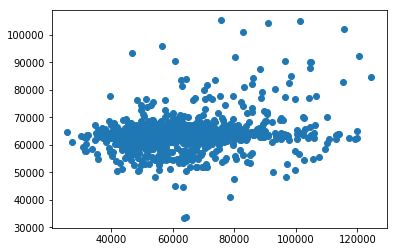

In [182]:
plt.scatter(Y_test,y_pred)

# Topographical arrangement

## Imports and configuration of the topography of the cap in use. 

The helper method returns a dictionary that maps keys from the dataframe to positions in an array for the given electrode. The latter may be passed to the mne printig function

In [631]:
import mne
import scipy.io
import re

In [632]:
mat = scipy.io.loadmat('acticap-64ch-standard2.mat')

In [633]:
coords = mat["lay"][0][0][0]

In [634]:
labels = [x[0][0] for x in mat["lay"]["label"][0][0]]

In [650]:
#1. What is the index for the df key?
#2. We know indices for mat names
#3. We need to match df-names to mat-names
dfk_to_matk = {}#dataframe key to matfile key

for k,v in df.items():
    #find out what label matches to current k
    found = False
    for l in labels:
        if "_"+ l +"_" in k:
            dfk_to_matk[k] = l
            found = True
        elif "_FCZ_" in k:
            dfk_to_matk[k] = "Ref"
            found = True
        elif "_V1_" in k:
            dfk_to_matk[k] = "Oz"
            found = True
        elif "_F10_" in k:
            dfk_to_matk[k] = "FT10"
            found = True
    if not found:
        #we didnt find a label (matfile) for the key
        #print(k)
        pass
    
#4. Remove umatched matnames and respective coordinates in parallel (readd them to new list)
used_matk = set(dfk_to_matk.values())
    

In [651]:
new_labels = []
new_coordinates = []
for used in used_matk:
    idx = labels.index(used)
    new_labels.append(labels[idx])
    new_coordinates.append(coords[idx])

#5. Match matfile key to index   
matk_to_idx = {}
for k in dfk_to_matk.values():
    matk_to_idx[k] = new_labels.index(k)
    
new_coordinates = np.array(new_coordinates)

In [652]:
matk_to_idx[dfk_to_matk["alpha_F7_1"]]

4

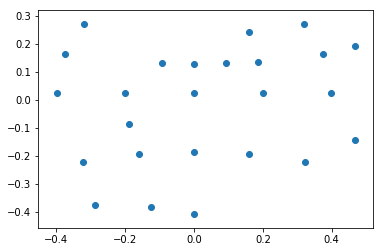

In [684]:
plt.scatter(new_coordinates[:,0],new_coordinates[:,1])

### Now we can print to head

In [466]:
channels = df.iloc[2500:7500,:].loc[:,"alpha_F7_1":"gamma2_V1_1"]

In [467]:
alpha = channels[channels.columns[::4]]
beta = channels[channels.columns[1::4]]
gamma1 = channels[channels.columns[2::4]]
gamma2 = channels[channels.columns[3::4]]

In [468]:
shifted_movement = df.iloc[2500:7500,:].loc[:,"shift_m2_head":"shift_m2_body"]

In [469]:
alpha_corr = pd.concat([alpha, shifted_movement],axis=1).corr().loc["shift_m2_head":"shift_m2_body",:"alpha_V1_1"]
beta_corr = pd.concat([beta, shifted_movement],axis=1).corr().loc["shift_m2_head":"shift_m2_body",:"beta_V1_1"]
gamma1_corr = pd.concat([gamma1, shifted_movement],axis=1).corr().loc["shift_m2_head":"shift_m2_body",:"gamma1_V1_1"]
gamma2_corr = pd.concat([gamma2, shifted_movement],axis=1).corr().loc["shift_m2_head":"shift_m2_body",:"gamma2_V1_1"]

In [584]:
power_for_electrode = np.zeros(25)#not all channels are used
power_for_electrode[:] = np.nan
for k, v in gamma2_corr.items():
    power_for_electrode[matk_to_idx[dfk_to_matk[k]]] = v[0]#for head, hands or body
    #print(k)
    #print(v[0])
    pass


In [585]:
#dict(gamma2_corr.iloc[:1])

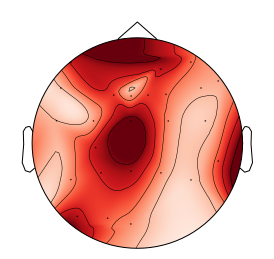

(<matplotlib.image.AxesImage at 0x7fe634cd66d8>,
 <matplotlib.contour.QuadContourSet at 0x7fe634cd6748>)

In [586]:
mne.viz.plot_topomap(power_for_electrode,np.array(new_coordinates))

In [339]:
import numpy as np
from scipy import interpolate

def fill_nan(A):
    '''
    interpolate to fill nan values
    '''
    inds = np.arange(A.shape[0])
    good = np.where(np.isfinite(A))
    f = interpolate.interp1d(inds[good], A[good],bounds_error=False)
    B = np.where(np.isfinite(A),A,f(inds))
    return B

# Supplementary depictions

In [ ]:
import matplotlib.pyplot as plt
gam = df["alpha_F7_1"]
body = df["body"]
head = df["head"]
hands = df["hands"]


body = body-np.mean(body)
head = head-np.mean(head)
hands = hands-np.mean(hands)

gam = gam-np.nanmean(gam)

#Generate new figure and define arrangement via grid specification

fig = plt.figure(figsize=(14, 20))
fig.subplots_adjust(top=0.95, wspace = 0.2,hspace=.4)

fig.suptitle("Figure 2: Crosscorrelation between movement and frequency band power")
gs = gridspec.GridSpec(3, 2,width_ratios=[1, 1],height_ratios=[6,2.5,2.5])

ax1 = plt.subplot2grid((5, 2), (0, 0), colspan=2)
ax2 = plt.subplot2grid((5, 2), (1, 0))
ax3 = plt.subplot2grid((5, 2), (1, 1))
ax4 = plt.subplot2grid((5, 2), (2, 0))
ax5 = plt.subplot2grid((5, 2), (2, 1))
ax6 = plt.subplot2grid((5, 2), (3, 0))
ax7 = plt.subplot2grid((5, 2), (3, 1))
ax8 = plt.subplot2grid((5, 2), (4, 0))
ax9 = plt.subplot2grid((5, 2), (4, 1))


# 1: Add first subplot: Sample trial alpha power and movement signals (unsmoothed)
ax1.plot((gam/np.max(gam)), label="Alpha Power (F7)")
ax1.plot(body/np.max(body), label="Body and arm movement")
ax1.plot(head/np.max(head), label="Head movement")
ax1.legend(loc='best')
ax1.set_xlabel("Frame")
ax1.set_ylabel("Movement Score /\n Alpha-Power")
ax1.set_title("A: Example for one recording including two blocks of Rock-Paper-Scissors (game period) and rest with closed eyes")

# 2: Add rest
maxshift = 350

titles = []
titles.append("A: Complete recording \n Correlation of alpha power (8 - 12 Hz) and head movement")
titles.append("B: Game period \n Correlation of alpha power (8 - 12 Hz) and head movement")

titles.append("C: Complete recording \n Correlation of alpha power (8 - 12 Hz) and hands movement")
titles.append("D: Game period \n Correlation of alpha power (8 - 12 Hz) and hands movement")

titles.append("E: Complete recording \n Correlation of gamma power (30 - 50 Hz) and head movement")
titles.append("F: Game period \n Correlation of gamma power (30 - 50 Hz) and head movement")

titles.append("G: Complete recording \n Correlation of gamma power (30 - 50 Hz) and hands movement")
titles.append("H: Game period \n Correlation of gamma power (30 - 50 Hz) and hands movement")

for ax, powers, mot, title in zip([ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9],[alpha,alpha_trial,alpha,alpha_trial,gamma,gamma_trial,gamma,gamma_trial],
                      [head_complete,head_trial,hands_complete, hands_trial,head_complete,head_trial,hands_complete, hands_trial],titles):
    ax.set_xlim(-14,14)

    ax.set_xticks(np.linspace(0,2*maxshift,9))
    ax.set_xticklabels(np.linspace(-maxshift/25,maxshift/25,9, dtype =np.int32))
    ax.set_xlabel("Relative shift of movement signal and frequency power (seconds)")
    ax.set_ylabel("Pearsons r")
    ax.set_title(title)

    for train in powers:
        print(".", end = "")
        if np.any(np.isnan(train)):
            print("Nan in eeg for" + title)
            train[np.isnan(train)] =0
        if np.any(np.isnan(mot)):
            print("Nan in motion for" + title)
            mot[np.isnan(mot)] =0
        c = helper.correlation_shifted(train,mot,maxshift)[0]
        ax.plot(helper.correlation_shifted(train,mot,maxshift)[0])

In [ ]:
import matplotlib.pyplot as plt
gam = df["alpha_F7_1"]
body = df["body"]
head = df["head"]
hands = df["hands"]


body = body-np.mean(body)
head = head-np.mean(head)
hands = hands-np.mean(hands)

gam = gam-np.nanmean(gam)

#Generate new figure and define arrangement via grid specification

fig = plt.figure(figsize=(14, 20))
fig.subplots_adjust(top=0.95, wspace = 0.2)

fig.suptitle("Figure 2: Correlation between movement and frequency band power")
gs = gridspec.GridSpec(3, 2,width_ratios=[1, 1],height_ratios=[6,2.5,2.5])

ax1 = plt.subplot2grid((5, 2), (0, 0), colspan=2)
ax2 = plt.subplot2grid((5, 2), (1, 0))
ax3 = plt.subplot2grid((5, 2), (1, 1))
ax4 = plt.subplot2grid((5, 2), (2, 0))
ax5 = plt.subplot2grid((5, 2), (2, 1))


# 1: Add first subplot: Sample trial alpha power and movement signals (unsmoothed)
ax1.plot((gam/np.max(gam)), label="Alpha Power (F7)")
ax1.plot(body/np.max(body), label="Body and arm movement")
ax1.plot(head/np.max(head), label="Head movement")
ax1.legend(loc='best')
ax1.set_xlabel("Frame")
ax1.set_ylabel("Movement Score /\n Alpha-Power")
ax1.set_title("A: Example for one experimental run including two trials of Rock-Paper-Scissors in the same condition and rest with closed eyes")

# 2: Add rest
maxshift = 350

titles = []
titles.append("B: Complete recording \n Correlation of alpha power (8 - 12 Hz) and head movement")
titles.append("C: Game period \n Correlation of alpha power (8 - 12 Hz) and head movement")
titles.append("D: Complete recording \n Correlation of gamma power (30 - 50 Hz) and hands movement")
titles.append("E: Game period \n Correlation of gamma power (30 - 50 Hz) and hands movement")

for ax, powers, mot, title in zip([ax2,ax3,ax4,ax5],[alpha,alpha_trial,gamma,gamma_trial],
                      [head_complete,head_trial,hands_complete, hands_trial],titles):
    ax.set_xlim(-14,14)

    ax.set_xticks(np.linspace(0,2*maxshift,9))
    ax.set_xticklabels(np.linspace(-maxshift/25,maxshift/25,9, dtype =np.int32))
    ax.set_xlabel("Relative shift of movement signal and frequency power (seconds)")
    ax.set_ylabel("Pearsons r")
    ax.set_title(title)

    for train in powers:
        print(".", end = "")
        if np.any(np.isnan(train)):
            print("Nan in eeg for" + title)
            train[np.isnan(train)] =0
        if np.any(np.isnan(mot)):
            print("Nan in motion for" + title)
            mot[np.isnan(mot)] =0
        c = helper.correlation_shifted(train,mot,maxshift)[0]
        ax.plot(helper.correlation_shifted(train,mot,maxshift)[0])